# Домашнее задание по теме "Элементарные методы анализа временных рядов"

## Задание

1. Возьмите из прошлого домашнего задания ряд - стационарный и не стационарный.
2. Приблизьте оба варианта молелями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

## 1. Выбор временного ряда

Для выполнения задания был выбран **Time Series "Monthly Boston Armed Robberies J"**

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### 1.1 Первичный вариант временного ряда

In [4]:
series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
series.head()

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [5]:
series = series['Count']

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


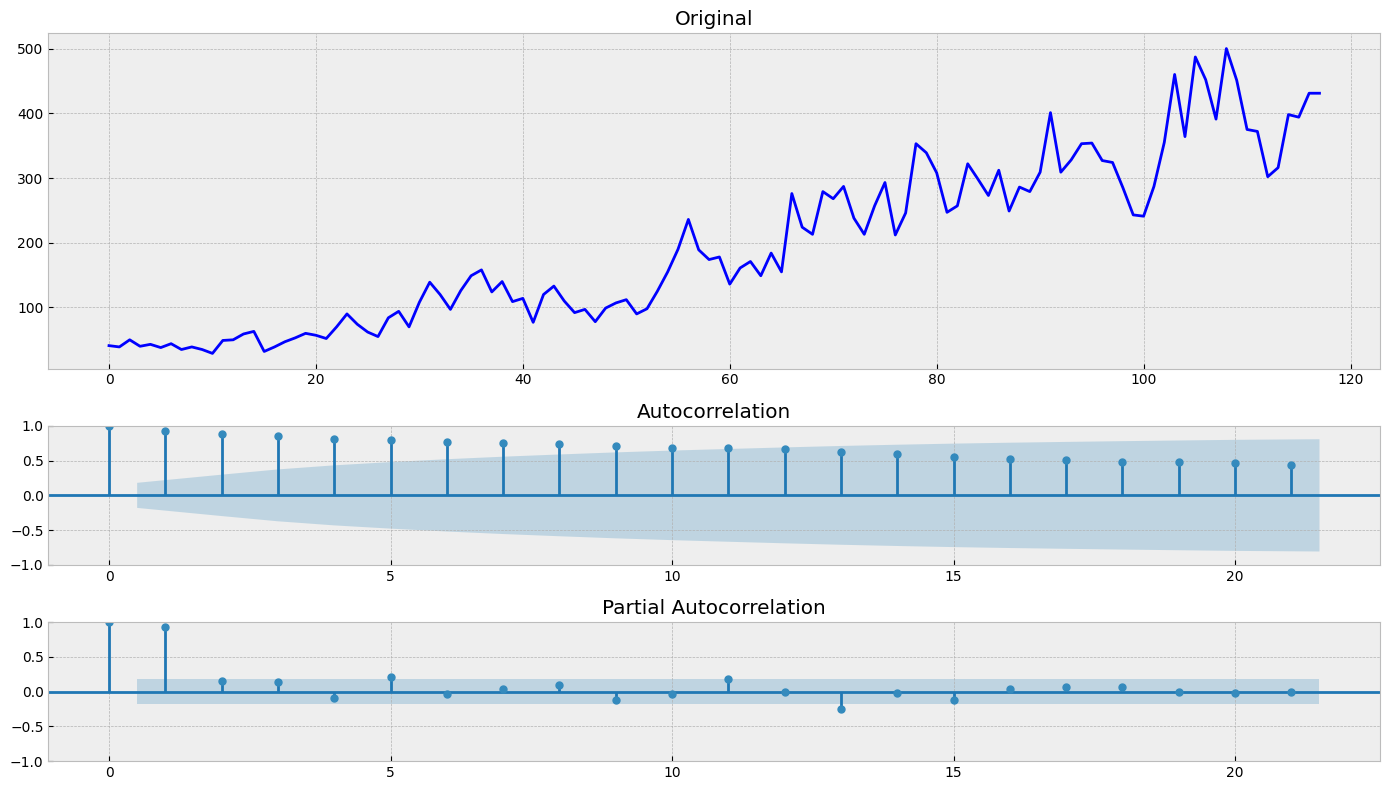

In [6]:
tsplot(series)

Временной ряд "Monthly Boston Armed Robberies J" не является стационарным по следующим признакам:
- Визуально налицо сезонность и тренд.
- Также значения мат ожидания и дисперсии на разных временных отрезках разные.
- Постепенное плавное снижение значения аутокорреляции.
- Тест Дики_Фуллера (p-value > 0.05)

### 1.2 Приведем временной ряд к стационарному виду

Выравниваем дисперсии:

In [7]:
series_stat = boxcox(series, 0)

Избавляемся от тренда:

In [8]:
series_stat = series_stat[1:] - series_stat[:-1]

Избавляемся от сезонности:

In [9]:
series_stat = series_stat[6:] - series_stat[:-6]

Проверяем результат:

Results of Dickey-Fuller Test:
Test Statistic                 -4.546815
p-value                         0.000162
#Lags Used                     12.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


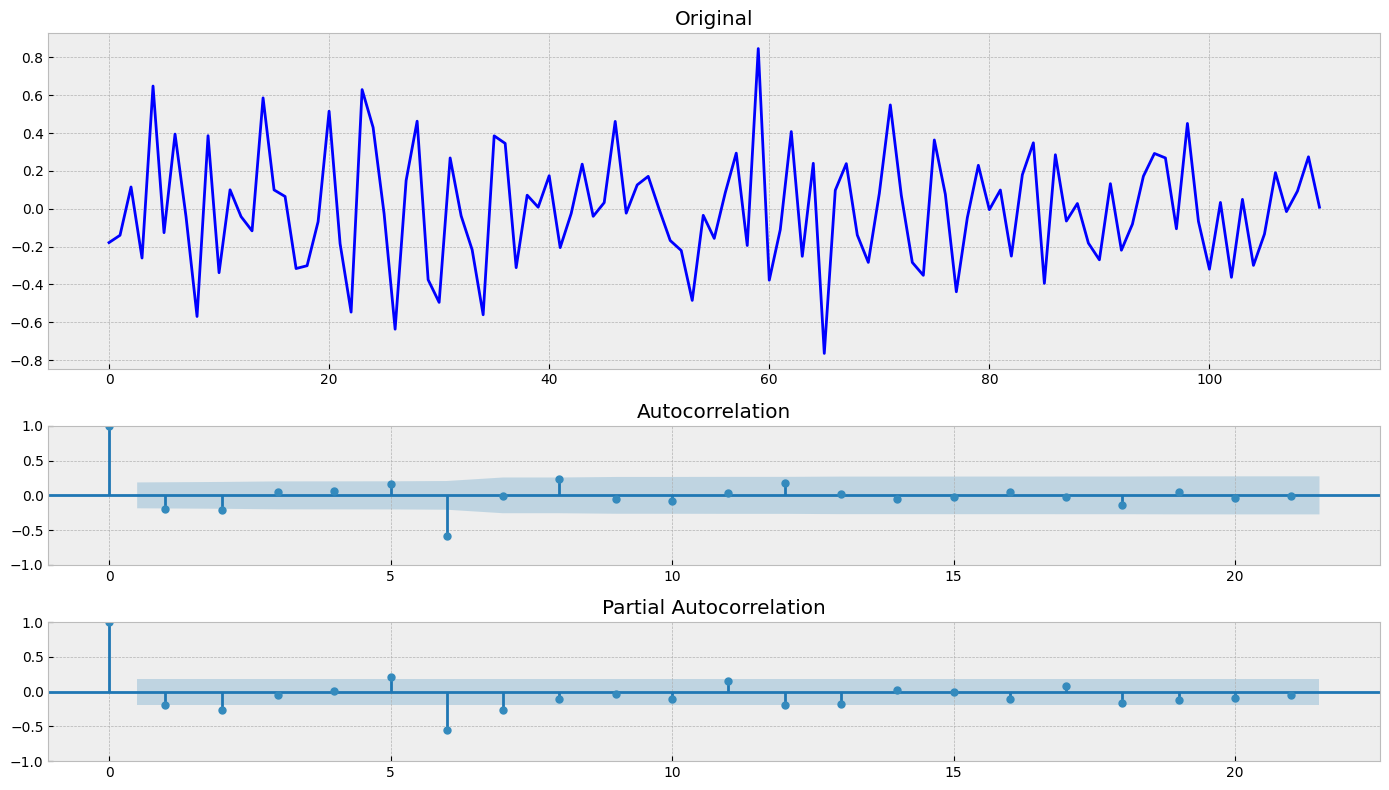

In [10]:
tsplot(series_stat)

- Мы избавились от тренда, разности дисперсии и сезонности.
- Временной ряд стал больше похож на шум.
- При проведении теста Дики-Фуллера значение **p-value** < 0.05.

## 2. Использование моделей из класса MA.

### 2.1 Приближение нестационарного временного ряда series

#### 2.1.1 MA

In [11]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [12]:
ser = moving_average(series, 6)

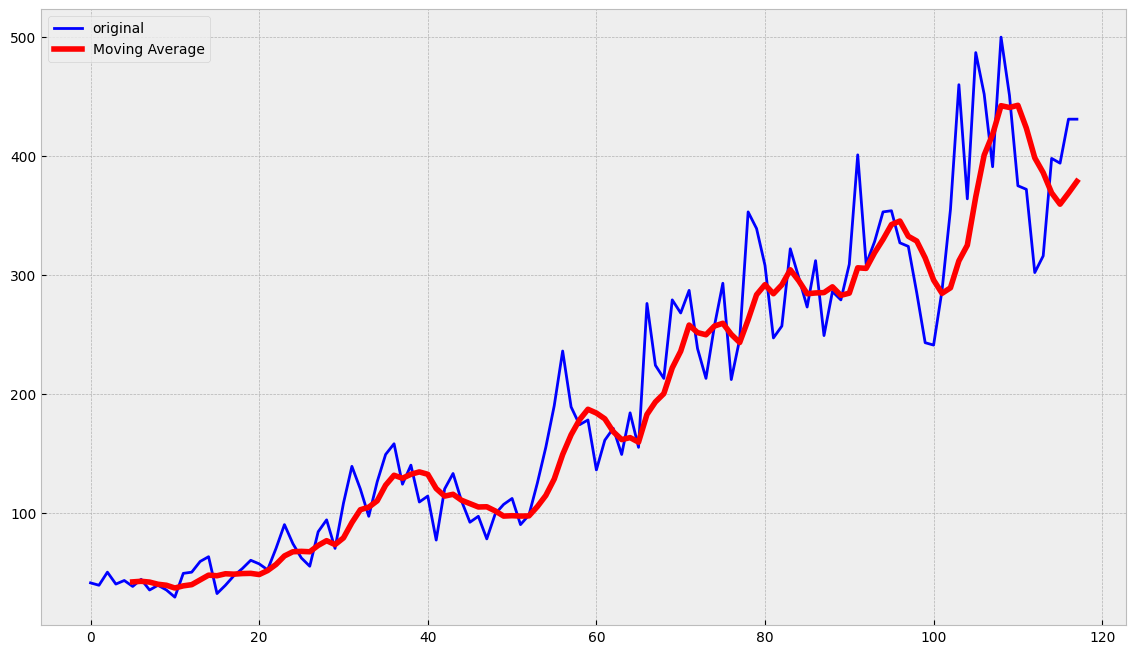

In [13]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth='2', label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [14]:
def moving_average_predict(series, n, n_pred):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    ma_series = series.rolling(n).mean()
    for _ in range(n_pred):
        ma_series = ma_series._append(pd.Series([ma_series[-n:].mean()]), ignore_index=True)
    return ma_series

In [15]:
series_predict = moving_average_predict(series, 6, 20)

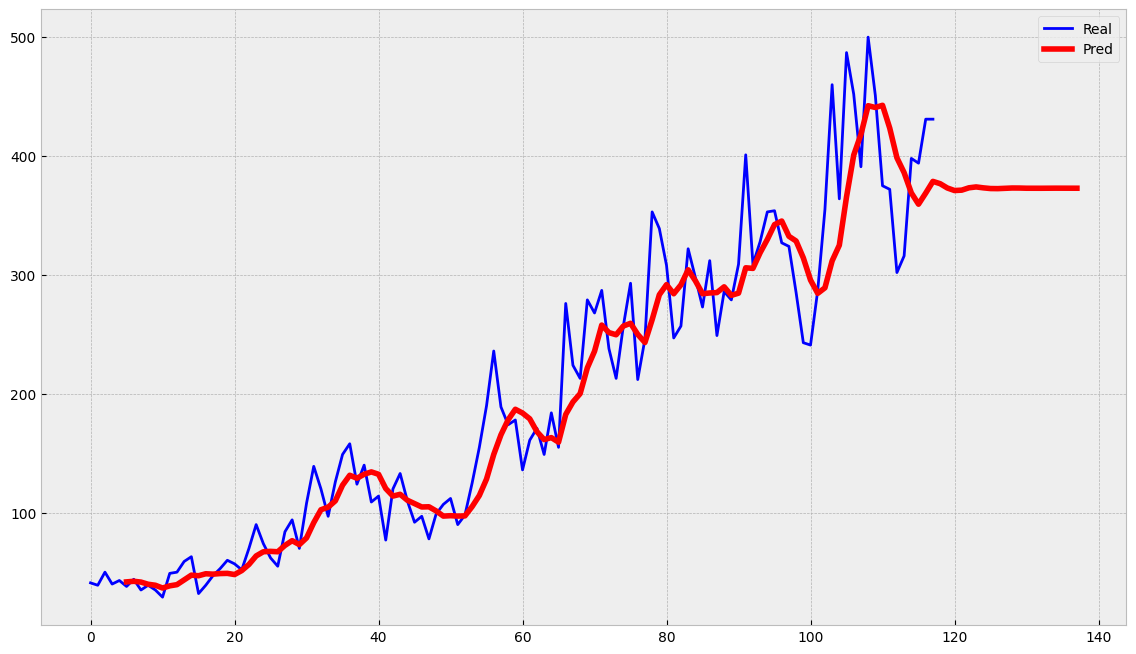

In [16]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth='2', label='Real')
    plt.plot(series_predict, color='red', linewidth='4', label='Pred')
    plt.legend()

#### 2.1.2 WMA

In [17]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

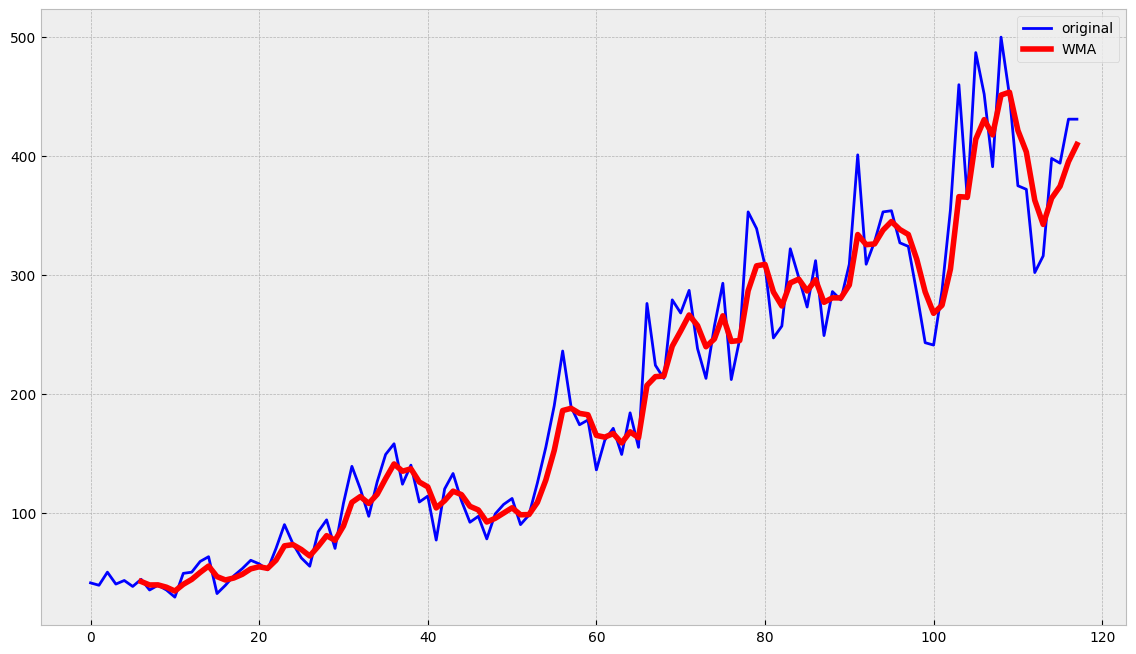

In [18]:
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='red', linewidth='4', label='WMA')        
    plt.legend()

In [19]:
def wma_predict(series, n, weights, n_pred):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma_series = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    for _ in range(n_pred):
        wma_series = wma_series._append(pd.Series([(wma_series[-n:] * (weights / weights.sum())).sum()]), ignore_index=True)
    return wma_series

In [20]:
wma_pred = wma_predict(series, 7, [1,1,2,3,5,8,13], 20)

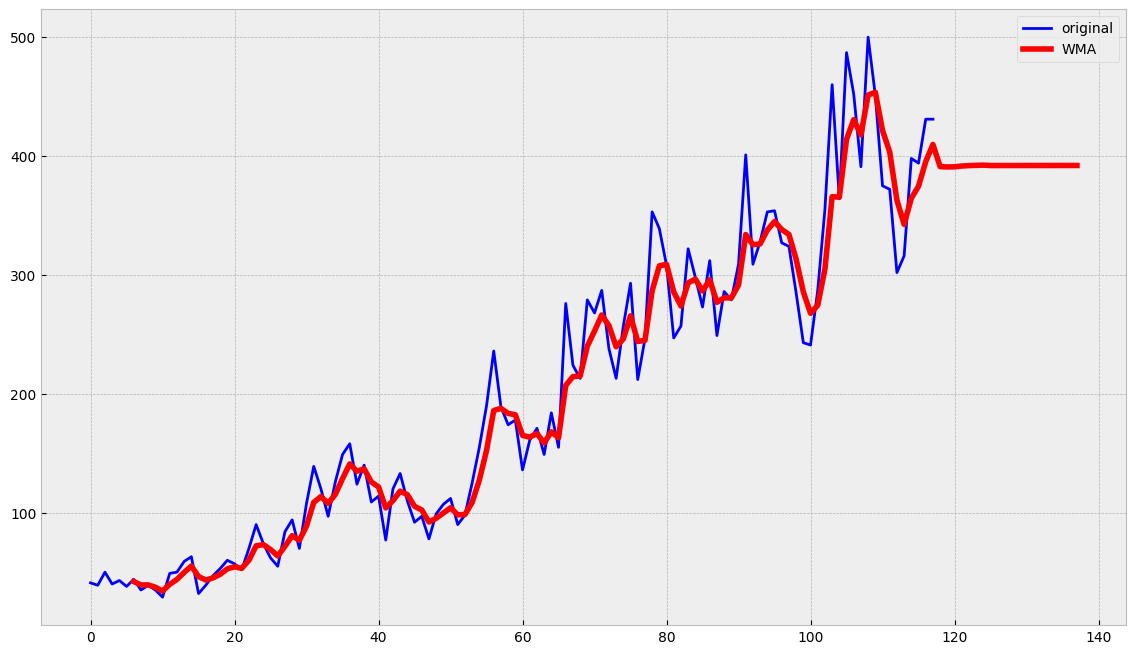

In [21]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth='2', label='original')
    plt.plot(wma_pred, color='red', linewidth='4', label='WMA')        
    plt.legend()

### 2.2 Приближение стационарного временного ряда series_stat

#### 2.2.1 MA

In [22]:
ser = moving_average(series_stat, 6)

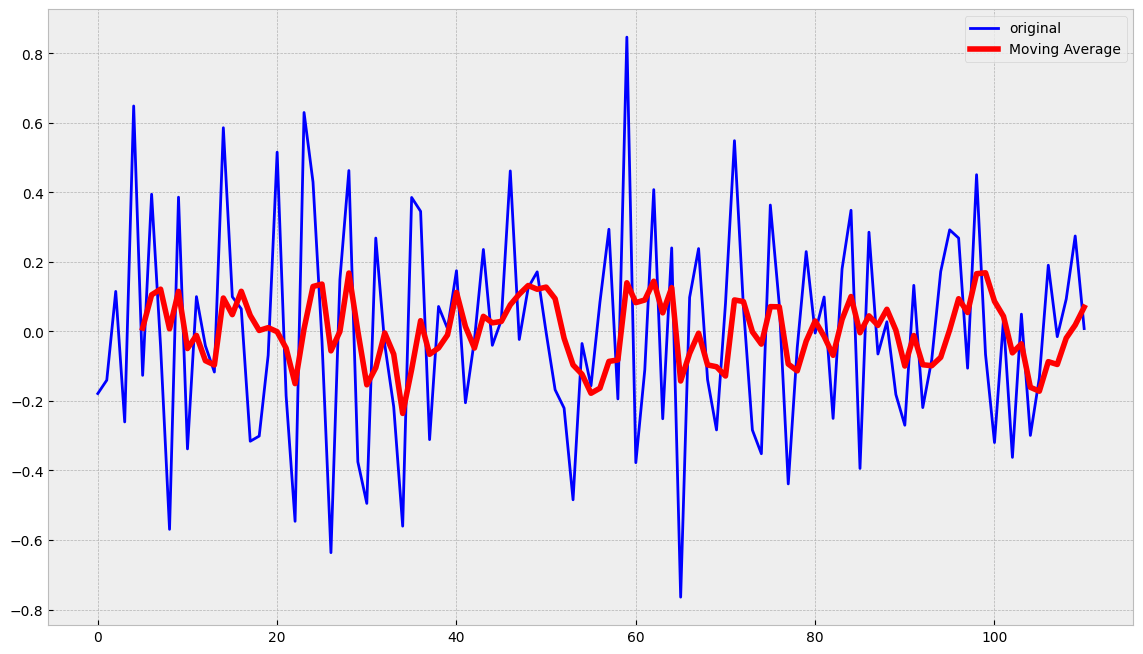

In [23]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

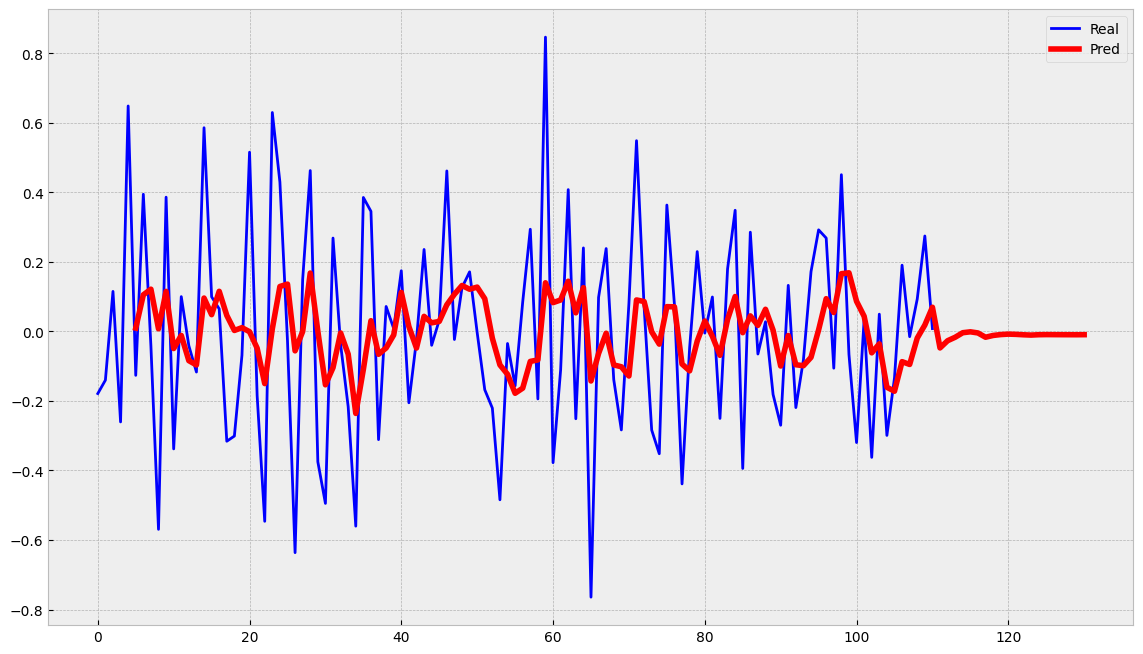

In [24]:
series_predict = moving_average_predict(series_stat, 6, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue', linewidth='2', label='Real')
    plt.plot(series_predict, color='red', linewidth='4', label='Pred')
    plt.legend()

#### 2.2.2 WMA

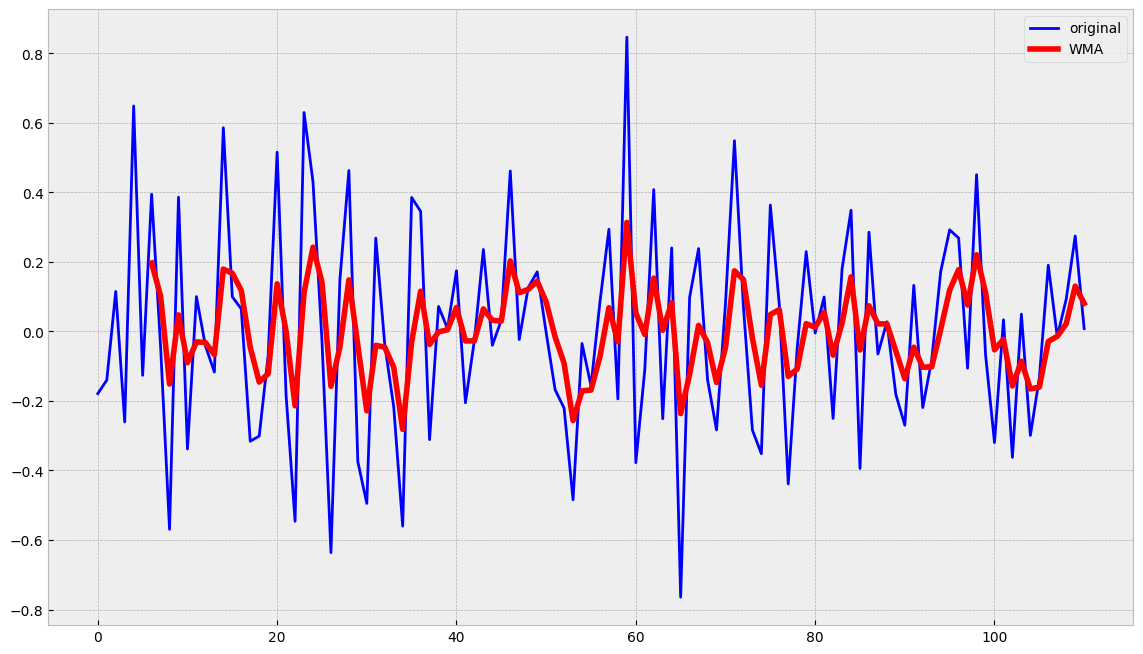

In [25]:
wma = weighted_moving_average(series_stat, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue',label='original')
    plt.plot(wma, color='red', linewidth='4', label='WMA')
    plt.legend()

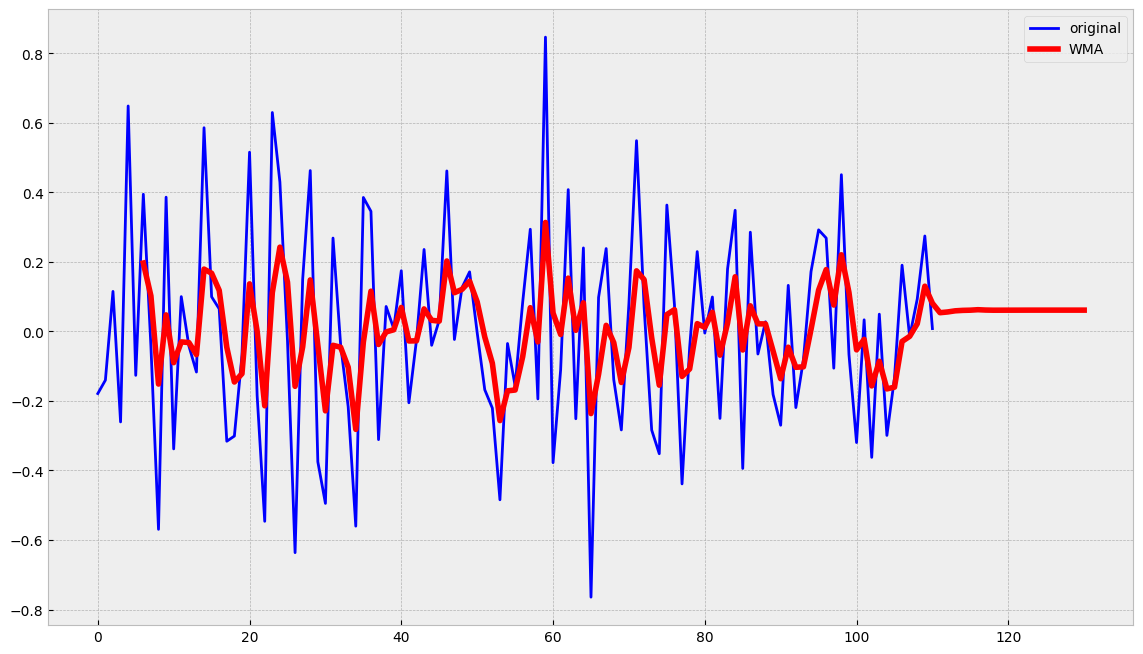

In [26]:
wma_pred = wma_predict(series_stat, 7, [1,1,2,3,5,8,13], 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stat, color='blue', linewidth='2', label='original')
    plt.plot(wma_pred, color='red', linewidth='4', label='WMA')        
    plt.legend()